In [1]:
from PIL import Image, ImageOps
from sklearn.decomposition import PCA
import numpy as np
import os
import matplotlib.pyplot as plt

In [6]:
def img_data(imgPath,disp = True):
    
    orig_img = Image.open(imgPath)
    
    img_size_kb = os.stat(imgPath).st_size/1024
    
    ori_pixels = np.array(orig_img.getdata()).reshape(*orig_img.size, -1)
    
    img_dim = ori_pixels.shape 
    
    if disp:
        plt.imshow(orig_img)
        plt.show()
    
    data_dict = {}
    data_dict['img_size_kb'] = img_size_kb
    data_dict['img_dim'] = img_dim
    
    return data_dict

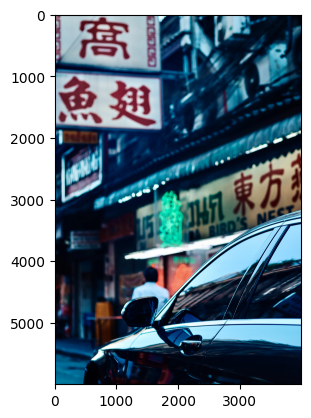

Original Image Data
Original Image size (kB) 2551.0732421875
Original Image Shape (4000, 6000, 3)


In [7]:
imgPath = 'image.jpg'

data_dict_ori = img_data(imgPath)

print('Original Image Data')
print('Original Image size (kB)',data_dict_ori['img_size_kb'])
print('Original Image Shape',data_dict_ori['img_dim'])

In [16]:
def pca_compose(imgPath):
    
    orig_img = Image.open(imgPath)
    # 1. Read the image
    orig_img = Image.open(imgPath)
    
    # 2. Convert the reading into a 2D numpy array
    img = np.array(orig_img.getdata())
    
    # 3. Reshape 2D to 3D array 
    # The asterisk (*) operator helps in unpacking the sequence/collection as positional arguments. 
    # So, instead of using indices of elements separately, we can use * and perform action on it.
    # print(orig_img.size) = (1024, 1024) --> print(*orig_img.size) = 1024 1024
    img = img.reshape(*orig_img.size, -1)
    
    # Seperate channels from image and use PCA on each channel
    pca_channel = {}
    img_t = np.transpose(img) # transposing the image 
    
    for i in range(img.shape[-1]):    # For each RGB channel compute the PCA
        
        per_channel = img_t[i] # It will be in a shape (1,1024,1024)
        
        # Converting (1, 1024, 1024) to (1024, 1024)
        channel = img_t[i].reshape(*img.shape[:-1])  # obtain channel
        
        pca = PCA(random_state = 42)                #initialize PCA
        
        fit_pca = pca.fit_transform(channel)        #fit PCA
        
        pca_channel[i] = (pca,fit_pca)  #save PCA models for each channel
        
    return pca_channel

In [17]:
pca_channel = pca_compose(imgPath)

In [18]:
def explained_var_n(pca_channel, n_components):
    
    var_exp_channel = []
    var_exp=0
    
    for channel in pca_channel:
        
        pca,_ = pca_channel[channel]
        
        var_exp_channel.append(np.cumsum(pca.explained_variance_ratio_))
        
        var_exp += var_exp_channel[channel][n_components]
        
    var_exp = var_exp/len(pca_channel)
    
    return var_exp


In [19]:
var_exp = explained_var_n(pca_channel, 1023)

print("Explained variance in percentage by PCA : ", var_exp*100,"%")


Explained variance in percentage by PCA :  99.89963591687282 %


In [20]:
# Function to plot the individual variance of every principal component
def variance_added_pc(pca_channel):
    
    var_exp_channel = [];var_exp=0;
    
    for channel in pca_channel:
        pca,_ = pca_channel[channel]
        var_exp_channel.append(pca.explained_variance_ratio_)
        
    var_exp = (var_exp_channel[0]+var_exp_channel[1]+var_exp_channel[2])/3
    
    x = list(var_exp);y = list(range(1,1+len(x)));y = list(range(1,21))
    
    plt.yticks(np.arange(0, max(x)+0.05,0.05))
    plt.xticks(np.arange(min(y), max(y)+1,1))
    plt.title("Individual Variance for each Principal Component")
    plt.ylabel('Variance')
    plt.xlabel('Principal Component');
    plt.bar(y,x[:20],color = 'black')
    #plt.grid(True)
    plt.show()

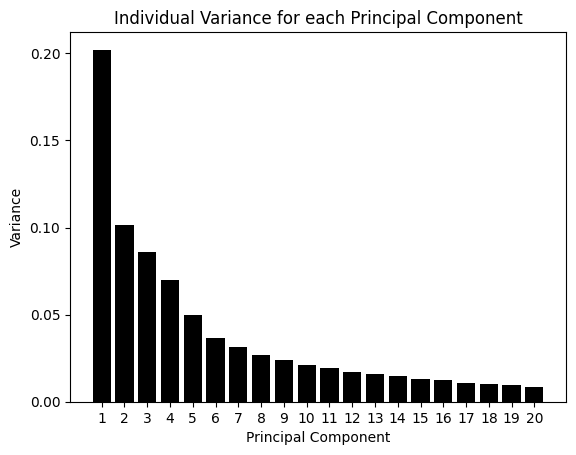

In [21]:
variance_added_pc(pca_channel)

In [22]:
# Function to plot the explained variance/information w.r.t the number of components

def plot_variance_pc(pca_channel):
    
    pca,fit_pca = pca_channel[0]
    
    exp_var = {}
    
    for i in range(len(pca.components_)):
        var_exp = explained_var_n(pca_channel,i)
        exp_var[i+1] = var_exp
    
    lists = sorted(exp_var.items()) # sorted by key, return a list of tuples
    
    x, y = zip(*lists) # unpack a list of pairs into two tuples
    
    pt90 = next(xx[0] for xx in enumerate(y) if xx[1] > 0.9)
    pt95 = next(xx[0] for xx in enumerate(y) if xx[1] > 0.95)
    
    plt.plot(x, y)
    plt.vlines(x=x[pt90], ymin=0, ymax=y[pt90], colors='green',  ls=':', lw=2, label=str('90% Variance Explained : n = '+str(x[pt90])))
    plt.vlines(x=x[pt95], ymin=0, ymax=y[pt95], colors='red', ls=':', lw=2, label=str('95% Variance Explained : n = '+str(x[pt95])))
    
    plt.xticks(np.arange(min(x)-1, max(x)-1,100))
    plt.yticks(np.arange(0, max(y),0.1))
    
    plt.legend(loc="lower right")
    plt.title("Variance vs Principal Components")
    plt.xlabel("Principal Components")
    plt.ylabel("Variance Explained")
    plt.grid(True)
    plt.show()

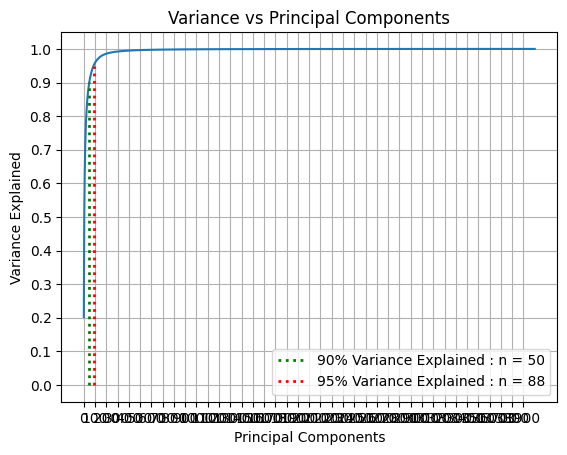

In [23]:
plot_variance_pc(pca_channel)

In [39]:
# So even if we select 50 components, the information retention will be huge.
n_components = 50

var_exp = explained_var_n(pca_channel, n_components)

print("Explained variance in percentage by PCA : ", var_exp*100,"%")

Explained variance in percentage by PCA :  90.39644339289072 %


In [41]:
# Function to select the desired number of components

def pca_transform(pca_channel, n_components):
    
    temp_res = []
    
    # Looping over all the channels we created from pca_compose function
    
    for channel in range(len(pca_channel)):
        
        pca, fit_pca = pca_channel[channel]
        
        # Selecting image pixels across first n components
        pca_pixel = fit_pca[:, :n_components]
        
        # First n-components
        pca_comp = pca.components_[:n_components, :]
        
        # Projecting the selected pixels along the desired n-components (De-standardization)
        compressed_pixel = np.dot(pca_pixel, pca_comp) + pca.mean_
        
        # Stacking channels corresponding to Red Green and Blue
        temp_res.append(compressed_pixel)
            
    # transforming (channel, width, height) to (height, width, channel)
    compressed_image = np.transpose(temp_res)
    
    # Forming the compressed image
    compressed_image = np.array(compressed_image,dtype=np.uint8)
    
    return compressed_image

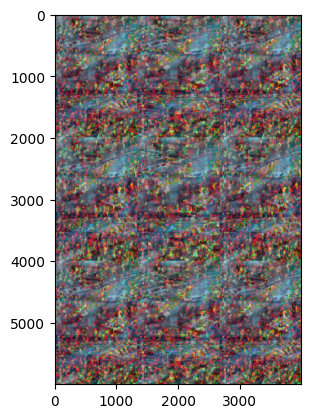

In [42]:
compressed_image = pca_transform(pca_channel,n_components=n_components)

# Display

plt.imshow(compressed_image)
plt.show()

Image.fromarray(compressed_image).save("compressed_img.jpeg")

# This will save the compressed image

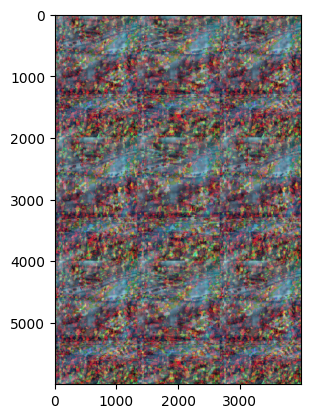

Compressed Image Data
Compressed Image size (kB) 9653.0712890625
Compression Percentage -278.3925576666377 %
Compressed Image Shape (4000, 6000, 3)


In [43]:
imgPath = 'compressed_img.jpeg';

data_dict_comp = img_data(imgPath)

print('Compressed Image Data')
print('Compressed Image size (kB)',data_dict_comp['img_size_kb'])
print('Compression Percentage', 100 - (data_dict_comp['img_size_kb']/data_dict_ori['img_size_kb'])*100,'%')
print('Compressed Image Shape',data_dict_comp['img_dim'])

In [44]:
# Function to plot the size of the compressed image w.r.t the number of components
def plot_size_pc(pca_channel):
    
    pca,fit_pca = pca_channel[0]
    kB = {}
    
    for i in range(len(pca.components_)):
        
        compressed_image = pca_transform(pca_channel,i)
        pil_img = Image.fromarray(compressed_image).save("loop_compressed_img.jpeg")
        size = os.stat('loop_compressed_img.jpeg').st_size/1024
        kB[i+1] = size
    
    lists = sorted(kB.items()) # sorted by key, return a list of tuples
    x, y = zip(*lists) # unpack a list of pairs into two tuples
    yy = []
    for i in range(len(y)):
        yy.append((max(y)-y[i])/max(y))
    
    yy = tuple(yy)
    pt20 = next(xx[0] for xx in enumerate(yy) if xx[1] < 0.2)
    pt50 = next(xx[0] for xx in enumerate(yy) if xx[1] < 0.5)
    
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    
    ax1.plot(x, y)
    ax1.set_ylabel('kB', color='b')
    ax1.set_xlabel("Principal Components")
    ax2 = ax1.twinx()
    ax1.set_title("Size vs Principal Components")
    ax2.plot(x, yy, 'r-')
    ax2.set_ylabel('% reduced', color='r')
    
    ax1.grid(True)
    ax2.vlines(x=x[pt20], ymin=0, ymax=yy[pt20], colors='green', ls=':', lw=2, label=str('20% Reduction : n = '+str(x[pt20])))
    ax2.vlines(x=x[pt50], ymin=0, ymax=yy[pt50], colors='orange', ls=':', lw=2, label=str('50% Reduction : n = '+str(x[pt50])))
    ax2.legend()


  

In [45]:
plot_size_pc(pca_channel)

KeyboardInterrupt: 